In [2]:
import os, sys
from tqdm import tqdm
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt

from src.features import intended_receiver, extract_player_pos, extract_pass
from src.visualization import plot_action
from src.preprocess_data import make_freeze_frame
from src.labels import get_intended_receiver

# this is very useful as it makes sure that always all columns and rows of a data frame are displayed
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

<h2> Data Load </h2>

In [3]:
match1 = pd.read_csv('../metrica-data/preprocess-data/tracking-data/match1.csv')
match2 = pd.read_csv('../metrica-data/preprocess-data/tracking-data/match2.csv')
match3 = pd.read_csv('../metrica-data/preprocess-data/tracking-data/match3.csv')
all_events = pd.read_csv('../metrica-data/EPV-data/all-match.csv')
all_events['freeze_frame'] = all_events['freeze_frame'].apply(ast.literal_eval)
all_events['Intended_Receiver'] = all_events['Intended_Receiver'].apply(ast.literal_eval)

In [5]:
all_events[all_events['event_id'] == 340]

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id
340,Away,BALL LOST,INTERCEPTION,1,24433,977.32,24486,979.44,B18,NaN,12.96,12.24,9.72,7.92,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B23', 'end_x': 21.5136, 'end_...",1,340


In [79]:
len(all_events[(all_events['accurate'] == 1)&
           (all_events['eventName'] == 'Pass')&
           (all_events['start_frame']< all_events['end_frame'])&
           (all_events['game_id'] == 2)])

964

In [4]:
all_events.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,B19,NaN,NaN,NaN,NaN,NaN,1,0,0,2,SET PIECE,{},NaN,0,{},1,0
1,Away,PASS,PASS,1,1,0.04,3,0.12,B19,B21,48.6,28.08,59.40,30.96,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B21', 'end_x': 59.66244, 'end...",1,1
2,Away,PASS,PASS,1,3,0.12,17,0.68,B21,B15,59.4,30.96,62.64,15.12,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B15', 'end_x': 63.06444, 'end...",1,2
3,Away,PASS,PASS,1,45,1.80,61,2.44,B15,B19,59.4,13.68,48.60,22.32,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B19', 'end_x': 48.33756, 'end...",1,3
4,Away,PASS,PASS,1,77,3.08,96,3.84,B19,B21,48.6,23.04,52.92,33.84,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B21', 'end_x': 52.67376, 'end...",1,4


### Intended-receiver 평가 지표

In [33]:
# 각 방식에 대한 정확도 계산
methods = ['dist', 'dist and angle', 'dist and narrow angle']

# 정확도를 계산하는 함수
def calculate_accuracy(events, method):
    correct_predictions = events.apply(lambda row: row['Intended_Receiver'][method]['ID'] == row['to'], axis=1)
    accuracy = correct_predictions.mean()
    return accuracy

<h3> Metrica 1</h3>

In [34]:
df_pass_success_1 = extract_pass(all_events[all_events["game_id"] == 1], match1)
df_pass_success_1.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd
0,Away,PASS,PASS,1,1,0.04,3,0.12,B19,B21,48.6,28.08,59.40,30.96,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B21', 'end_x': 59.66244, 'end...",1,1,49.10976,27.87048,1,58.01328,30.64032,1
1,Away,PASS,PASS,1,3,0.12,17,0.68,B21,B15,59.4,30.96,62.64,15.12,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B15', 'end_x': 63.06444, 'end...",1,2,58.01328,30.64032,1,62.09568,14.86008,1
2,Away,PASS,PASS,1,45,1.80,61,2.44,B15,B19,59.4,13.68,48.60,22.32,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B19', 'end_x': 48.33756, 'end...",1,3,59.34168,13.63032,1,48.96828,21.89952,1
3,Away,PASS,PASS,1,77,3.08,96,3.84,B19,B21,48.6,23.04,52.92,33.84,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B21', 'end_x': 52.67376, 'end...",1,4,48.89700,22.79952,1,52.43940,34.04376,1
4,Away,PASS,PASS,1,191,7.64,217,8.68,B21,B22,43.2,52.56,34.56,70.56,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B22', 'end_x': 33.16356, 'end...",1,5,43.45920,52.37136,1,34.66584,69.85224,1


In [35]:
df_pass_success_1 = make_freeze_frame(df_pass_success_1.reset_index(drop=True), match1)
df_pass_success_1 = get_intended_receiver(df_pass_success_1)

100%|██████████| 797/797 [00:07<00:00, 104.36it/s]


In [36]:
df_pass_success_1.loc[2, 'Intended_Receiver']

{'dist': {'ID': 'B19', 'end_x': 48.33756, 'end_y': 22.77072},
 'dist and angle': {'ID': 'B19', 'end_x': 48.33756, 'end_y': 22.77072},
 'dist and narrow angle': {'ID': 'B19', 'end_x': 48.33756, 'end_y': 22.77072}}

In [75]:
accuracies= {method: calculate_accuracy(df_pass_success_1, method) for method in methods}
accuracies

{'dist': 0.9698870765370138,
 'dist and angle': 0.8971141781681304,
 'dist and narrow angle': 0.821831869510665}

<h3> Metrica 2</h3>

In [76]:
df_pass_success_2 = extract_pass(all_events[all_events["game_id"] == 2], match2)
df_pass_success_2.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd
0,Away,PASS,PASS,1,51,2.04,87,3.48,B23,B20,54.00,36.00,43.20,36.72,1,0,0,2,Pass,"{'A01': {'teammate': False, 'actor': False, 'b...",1.0,0,"{'dist': {'ID': 'B20', 'end_x': 64.75464, 'end...",2,1746,54.23328,36.27072,1,43.83504,36.59544,1
1,Away,PASS,PASS,1,146,5.84,186,7.44,B20,B18,46.44,36.00,47.52,15.84,1,0,0,2,Pass,"{'A01': {'teammate': False, 'actor': False, 'b...",1.0,0,"{'dist': {'ID': 'B18', 'end_x': 63.23184, 'end...",2,1747,45.88488,36.14760,1,47.85372,16.16544,1
2,Away,PASS,PASS,1,248,9.92,283,11.32,B18,B17,50.76,13.68,33.48,20.16,1,0,0,2,Pass,"{'A01': {'teammate': False, 'actor': False, 'b...",1.0,0,"{'dist': {'ID': 'B17', 'end_x': 73.34388, 'end...",2,1748,50.23620,13.48488,1,33.75216,20.10600,1
3,Away,PASS,PASS,1,316,12.64,346,13.84,B17,B16,31.32,23.04,28.08,41.76,1,0,0,2,Pass,"{'A01': {'teammate': False, 'actor': False, 'b...",1.0,0,"{'dist': {'ID': 'B16', 'end_x': 77.99004, 'end...",2,1749,31.75632,22.69584,1,28.44720,41.01552,1
4,Away,PASS,PASS,1,395,15.80,423,16.92,B16,B15,28.08,47.52,29.16,65.52,1,0,0,2,Pass,"{'A01': {'teammate': False, 'actor': False, 'b...",1.0,0,"{'dist': {'ID': 'B15', 'end_x': 76.3614, 'end_...",2,1750,27.77436,47.25504,1,28.99368,65.00520,1


In [77]:
df_pass_success_2 = make_freeze_frame(df_pass_success_2.reset_index(drop=True), match2)
df_pass_success_2 = get_intended_receiver(df_pass_success_2)

100%|██████████| 964/964 [00:09<00:00, 104.71it/s]


In [80]:
df_pass_success_2.loc[2, 'Intended_Receiver']

{'dist': {'ID': 'B17', 'end_x': 34.65612, 'end_y': 21.1824},
 'dist and angle': {'ID': 'B17', 'end_x': 34.65612, 'end_y': 21.1824},
 'dist and narrow angle': {'ID': 'B17', 'end_x': 34.65612, 'end_y': 21.1824}}

In [81]:
accuracies = {method: calculate_accuracy(df_pass_success_2, method) for method in methods}
accuracies

{'dist': 0.9761410788381742,
 'dist and angle': 0.9201244813278008,
 'dist and narrow angle': 0.8402489626556017}

<h3> Metrica 3</h3>

In [73]:
df_pass_success_3 = all_events[all_events["game_id"] == 3]
df_pass_success_3.replace({'team': {'Away': 'Home', 'Home': 'Away'}}, inplace=True)

df_pass_success_3 = extract_pass(df_pass_success_3, match3)
df_pass_success_3.head()

3620


C:\Users\M207\AppData\Local\Temp\ipykernel_8896\4289867993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pass_success_3.replace({'team': {'Away': 'Home', 'Home': 'Away'}}, inplace=True)


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd
0,Home,PASS,PASS,1,361,14.44,377,15.08,A10,A07,54.13500,35.08200,53.85312,35.06760,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A07', 'end_x': 54.13716, 'end...",3,3681,54.13500,35.08200,1,53.86392,35.06832,1
1,Home,PASS,PASS,1,384,15.36,426,17.04,A07,A08,53.67600,34.92000,68.44284,45.68328,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A08', 'end_x': 66.78936, 'end...",3,3683,53.70192,34.94304,1,68.12100,45.44928,1
2,Home,PASS,PASS,1,465,18.60,507,20.28,A08,A02,72.34488,42.98904,87.05016,28.67112,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A02', 'end_x': 84.64716, 'end...",3,3685,72.21960,43.09560,1,86.88600,28.83096,1
3,Home,PASS,PASS,1,530,21.20,580,23.20,A02,A03,87.40332,30.90384,86.29848,58.69584,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A03', 'end_x': 85.1742, 'end_...",3,3687,87.36120,30.85992,1,86.30388,58.57056,1
4,Home,PASS,PASS,1,598,23.92,628,25.12,A03,A04,86.13648,59.03856,73.54908,70.60248,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A04', 'end_x': 73.46808, 'end...",3,3689,86.14188,59.02272,1,73.72728,70.43904,1


In [74]:
df_pass_success_3 = make_freeze_frame(df_pass_success_3.reset_index(drop=True), match3)
df_pass_success_3 = get_intended_receiver(df_pass_success_3)

100%|██████████| 1121/1121 [00:12<00:00, 89.83it/s]


In [82]:
df_pass_success_3.loc[2, 'Intended_Receiver']

{'dist': {'ID': 'A02', 'end_x': 84.64716, 'end_y': 29.08728},
 'dist and angle': {'ID': 'A02', 'end_x': 84.64716, 'end_y': 29.08728},
 'dist and narrow angle': {'ID': 'A02', 'end_x': 84.64716, 'end_y': 29.08728}}

In [83]:
accuracies = {method: calculate_accuracy(df_pass_success_3, method) for method in methods}
accuracies

{'dist': 0.9598572702943801,
 'dist and angle': 0.9000892060660125,
 'dist and narrow angle': 0.8126672613737734}

### Success_all_match.csv



In [84]:
success_all_match = pd.concat([df_pass_success_1, df_pass_success_2, df_pass_success_3])
success_all_match.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd
0,Away,PASS,PASS,1,1,0.04,3,0.12,B19,B21,48.6,28.08,59.40,30.96,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B21', 'end_x': 59.66244, 'end...",1,1,49.10976,27.87048,1,58.01328,30.64032,1
1,Away,PASS,PASS,1,3,0.12,17,0.68,B21,B15,59.4,30.96,62.64,15.12,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B15', 'end_x': 63.06444, 'end...",1,2,58.01328,30.64032,1,62.09568,14.86008,1
2,Away,PASS,PASS,1,45,1.80,61,2.44,B15,B19,59.4,13.68,48.60,22.32,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B19', 'end_x': 48.33756, 'end...",1,3,59.34168,13.63032,1,48.96828,21.89952,1
3,Away,PASS,PASS,1,77,3.08,96,3.84,B19,B21,48.6,23.04,52.92,33.84,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B21', 'end_x': 52.67376, 'end...",1,4,48.89700,22.79952,1,52.43940,34.04376,1
4,Away,PASS,PASS,1,191,7.64,217,8.68,B21,B22,43.2,52.56,34.56,70.56,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'B22', 'end_x': 33.16356, 'end...",1,5,43.45920,52.37136,1,34.66584,69.85224,1


c:\Users\M207\Desktop\kang\code_factory\EPV_intended\EPV\src\preprocess_data.py:180: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  freezedf[player]["start_x"] = field_dimen[0] - freezedf[player]["start_x"]
c:\Users\M207\Desktop\kang\code_fac

KeyError: 'subEventName'

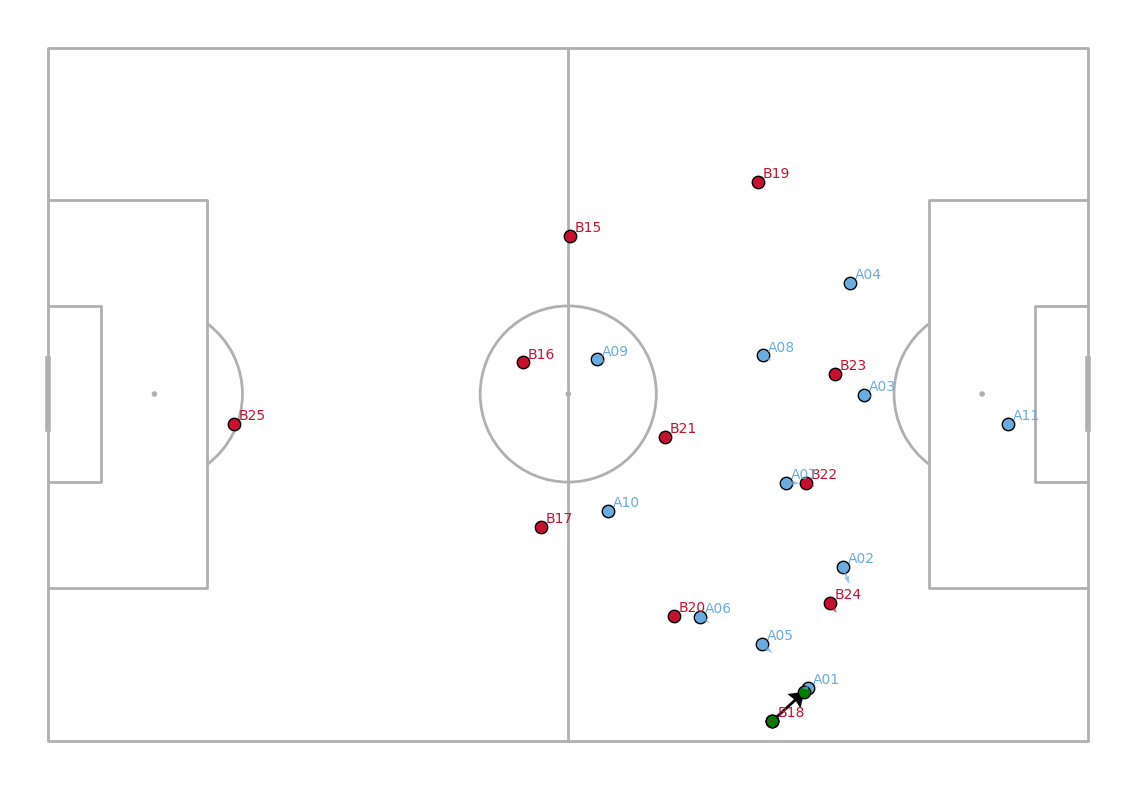

In [85]:
plot_action(all_events.loc[all_events['event_id'] == 2335].squeeze(), field_dimen=(108,72))  #left_to_right=True,

In [86]:
accuracies = {method: calculate_accuracy(success_all_match, method) for method in methods}
accuracies

{'dist': 0.9680777238029147,
 'dist and angle': 0.905968077723803,
 'dist and narrow angle': 0.8244274809160306}

In [88]:
success_all_match.to_csv('../metrica-data/EPV-data/all-match-success.csv')

### Unsuccess_all_match.csv

In [109]:
match = [match1, match2, match3]
unsuccess_match = []

for i in range(1, 4):
    df_pass_unsuccess = all_events[all_events["game_id"] == i]
    if i == 3:
        df_pass_unsuccess.replace({'team': {'Away': 'Home', 'Home': 'Away'}}, inplace=True)
    df_pass_unsuccess = extract_pass(df_pass_unsuccess, match[i-1], 0)
    unsuccess_match.append(df_pass_unsuccess)

C:\Users\M207\AppData\Local\Temp\ipykernel_8896\3932208390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pass_unsuccess.replace({'team': {'Away': 'Home', 'Home': 'Away'}}, inplace=True)


In [110]:
unsuccess_all_match = pd.concat(unsuccess_match)
# unsuccess_all_match.to_csv('../metrica-data/EPV-data/all-match-unsuccess.csv')

unsuccess_all_match.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd
6,Away,BALL LOST,INTERCEPTION,1,346,13.84,380,15.20,B17,NaN,55.08,69.84,29.16,54.00,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B18', 'end_x': 34.398, 'end_y...",1,7,54.98172,69.67944,1,29.59956,55.85472,1
7,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,A02,NaN,29.16,56.16,63.72,46.08,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A10', 'end_x': 51.99768, 'end...",1,9,28.94400,56.04264,1,63.31068,46.19736,1
10,Home,BALL LOST,INTERCEPTION,1,572,22.88,616,24.64,A10,NaN,54.00,46.80,72.36,31.68,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A08', 'end_x': 60.2208, 'end_...",1,17,54.22572,47.08224,1,72.33948,31.69800,1
15,Away,BALL LOST,INTERCEPTION,1,1110,44.40,1134,45.36,B17,NaN,45.36,56.88,33.48,60.48,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B21', 'end_x': 29.4732, 'end_...",1,23,45.40860,56.76984,1,34.44228,63.78912,1
19,Home,BALL LOST,INTERCEPTION,1,1370,54.80,1375,55.00,A08,NaN,92.88,18.72,95.04,20.16,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A09', 'end_x': 95.44284, 'end...",1,28,92.51280,19.03032,1,94.72680,19.98720,1


### Unsuccess Intended Receiver Baseline 확인

In [111]:
# 각 방식에 대한 정확도 계산
methods = ['dist', 'dist and angle', 'dist and narrow angle']

# 정확도를 계산하는 함수
def calculate_accuracy(events, method):
    correct_predictions = events.apply(lambda row: row['Intended_Receiver'][method]['ID'] == row['Intended_labelling'], axis=1)
    accuracy = correct_predictions.mean()
    return accuracy

In [112]:
un_label = pd.read_excel('unsuccess_labelling.xlsx', index_col=0)
un_label = un_label[un_label['Intended_labelling'].isna() == False]
un_label.head()

,type,subtype,game_id,event_id,from,Mingu
6,BALL LOST,INTERCEPTION,1,7,B17,24.0
7,BALL LOST,INTERCEPTION,1,9,A02,10.0
10,BALL LOST,INTERCEPTION,1,17,A10,8.0
15,BALL LOST,INTERCEPTION,1,23,B17,21.0
19,BALL LOST,INTERCEPTION,1,28,A08,9.0


In [113]:
# to/from 양식과 똑같이 만들어주기 위해
m_list = []
for idx, action in un_label.iterrows():
    num = str(int(action['Intended_labelling']))
    if len(num) == 1:
        m = action['from'][0] + '0' + num
    else:
        m = action['from'][0] + num
    m_list.append(m)
un_label['Intended_labelling'] = m_list

un_label.head()

,type,subtype,game_id,event_id,from,Mingu
6,BALL LOST,INTERCEPTION,1,7,B17,B24
7,BALL LOST,INTERCEPTION,1,9,A02,A10
10,BALL LOST,INTERCEPTION,1,17,A10,A08
15,BALL LOST,INTERCEPTION,1,23,B17,B21
19,BALL LOST,INTERCEPTION,1,28,A08,A09


#### Metrica 1

In [114]:
unsuccess_metrica_1 = unsuccess_all_match[unsuccess_all_match['game_id'] == 1].copy()
un_label1 = un_label[un_label['game_id'] == 1].copy()

In [115]:
# join
df_un_1 = pd.merge(unsuccess_metrica_1, un_label1[['event_id', 'Intended_labelling']], how='inner', on='event_id')
# labelling 된 것들만
df_un_1 = df_un_1[df_un_1['Intended_labelling'].isna() == False].copy()

df_un_1.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd,Mingu
0,Away,BALL LOST,INTERCEPTION,1,346,13.84,380,15.20,B17,NaN,55.08,69.84,29.16,54.00,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B18', 'end_x': 34.398, 'end_y...",1,7,54.98172,69.67944,1,29.59956,55.85472,1,B24
1,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,A02,NaN,29.16,56.16,63.72,46.08,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A10', 'end_x': 51.99768, 'end...",1,9,28.94400,56.04264,1,63.31068,46.19736,1,A10
2,Home,BALL LOST,INTERCEPTION,1,572,22.88,616,24.64,A10,NaN,54.00,46.80,72.36,31.68,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A08', 'end_x': 60.2208, 'end_...",1,17,54.22572,47.08224,1,72.33948,31.69800,1,A08
3,Away,BALL LOST,INTERCEPTION,1,1110,44.40,1134,45.36,B17,NaN,45.36,56.88,33.48,60.48,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B21', 'end_x': 29.4732, 'end_...",1,23,45.40860,56.76984,1,34.44228,63.78912,1,B21
4,Home,BALL LOST,INTERCEPTION,1,1370,54.80,1375,55.00,A08,NaN,92.88,18.72,95.04,20.16,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A09', 'end_x': 95.44284, 'end...",1,28,92.51280,19.03032,1,94.72680,19.98720,1,A09


In [117]:
un_intended_1 = make_freeze_frame(df_un_1.reset_index(drop=True), match1)
un_intended_1 = get_intended_receiver(un_intended_1)
un_intended_1.head()

100%|██████████| 145/145 [00:01<00:00, 126.93it/s]


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd,Mingu
0,Away,BALL LOST,INTERCEPTION,1,346,13.84,380,15.20,B17,NaN,55.08,69.84,29.16,54.00,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B18', 'end_x': 34.398, 'end_y...",1,7,54.98172,69.67944,1,29.59956,55.85472,1,B24
1,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,A02,NaN,29.16,56.16,63.72,46.08,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A10', 'end_x': 51.99768, 'end...",1,9,28.94400,56.04264,1,63.31068,46.19736,1,A10
2,Home,BALL LOST,INTERCEPTION,1,572,22.88,616,24.64,A10,NaN,54.00,46.80,72.36,31.68,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A08', 'end_x': 60.2208, 'end_...",1,17,54.22572,47.08224,1,72.33948,31.69800,1,A08
3,Away,BALL LOST,INTERCEPTION,1,1110,44.40,1134,45.36,B17,NaN,45.36,56.88,33.48,60.48,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B21', 'end_x': 29.4732, 'end_...",1,23,45.40860,56.76984,1,34.44228,63.78912,1,B21
4,Home,BALL LOST,INTERCEPTION,1,1370,54.80,1375,55.00,A08,NaN,92.88,18.72,95.04,20.16,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A09', 'end_x': 95.44284, 'end...",1,28,92.51280,19.03032,1,94.72680,19.98720,1,A09


In [118]:
accuracies = {method: calculate_accuracy(un_intended_1, method) for method in methods}
accuracies

{'dist': 0.7724137931034483,
 'dist and angle': 0.7448275862068966,
 'dist and narrow angle': 0.5310344827586206}

#### Metrica 2

In [119]:
unsuccess_metrica_2 = unsuccess_all_match[unsuccess_all_match['game_id'] == 2].copy()
un_label2 = un_label[un_label['game_id'] == 2].copy()

In [120]:
# join
df_un_2 = pd.merge(unsuccess_metrica_2, un_label2[['event_id', 'Intended_labelling']], how='inner', on='event_id')
df_un_2.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd,Mingu
0,Away,BALL LOST,INTERCEPTION,1,451,18.04,504,20.16,B15,NaN,28.08,66.24,69.12,66.96,1,0,0,2,Pass,"{'A01': {'teammate': False, 'actor': False, 'b...",0.0,0,"{'dist': {'ID': 'B23', 'end_x': 44.75196, 'end...",2,1751,28.14696,66.14856,1,67.18464,66.46680,1,B23
1,Away,BALL LOST,INTERCEPTION,1,1016,40.64,1087,43.48,B16,NaN,16.20,64.80,55.08,50.40,1,0,0,2,Pass,"{'A01': {'teammate': False, 'actor': False, 'b...",0.0,0,"{'dist': {'ID': 'B24', 'end_x': 48.48984, 'end...",2,1762,16.11576,64.70784,1,53.59716,53.39592,1,B24
2,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,B24,NaN,77.76,2.88,93.96,9.36,1,0,0,2,Pass,"{'A01': {'teammate': False, 'actor': False, 'b...",0.0,0,"{'dist': {'ID': 'B22', 'end_x': 21.22307999999...",2,1771,77.67684,2.85408,1,93.67056,9.24120,1,B22
3,Home,BALL LOST,INTERCEPTION,1,1578,63.12,1611,64.44,A09,NaN,63.72,10.08,56.16,20.88,1,0,0,1,Pass,"{'A01': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A10', 'end_x': 52.21584, 'end...",2,1777,63.75132,10.32552,1,56.18808,20.83968,1,A10
4,Away,BALL LOST,INTERCEPTION,1,1843,73.72,1876,75.04,B15,NaN,60.48,60.48,74.52,51.84,1,0,0,2,Pass,"{'A01': {'teammate': False, 'actor': False, 'b...",0.0,0,"{'dist': {'ID': 'B21', 'end_x': 41.21928, 'end...",2,1786,60.79104,59.80536,1,72.87732,51.47928,1,B24


In [121]:
un_intended_2 = make_freeze_frame(df_un_2.reset_index(drop=True), match2)
un_intended_2 = get_intended_receiver(un_intended_2)
un_intended_2.head()

100%|██████████| 123/123 [00:01<00:00, 78.39it/s]


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd,Mingu
0,Away,BALL LOST,INTERCEPTION,1,451,18.04,504,20.16,B15,NaN,28.08,66.24,69.12,66.96,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B23', 'end_x': 63.24804, 'end...",2,1751,28.14696,66.14856,1,67.18464,66.46680,1,B23
1,Away,BALL LOST,INTERCEPTION,1,1016,40.64,1087,43.48,B16,NaN,16.20,64.80,55.08,50.40,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B24', 'end_x': 59.51016, 'end...",2,1762,16.11576,64.70784,1,53.59716,53.39592,1,B24
2,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,B24,NaN,77.76,2.88,93.96,9.36,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B22', 'end_x': 86.77692, 'end...",2,1771,77.67684,2.85408,1,93.67056,9.24120,1,B22
3,Home,BALL LOST,INTERCEPTION,1,1578,63.12,1611,64.44,A09,NaN,63.72,10.08,56.16,20.88,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A10', 'end_x': 55.78416, 'end...",2,1777,63.75132,10.32552,1,56.18808,20.83968,1,A10
4,Away,BALL LOST,INTERCEPTION,1,1843,73.72,1876,75.04,B15,NaN,60.48,60.48,74.52,51.84,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B21', 'end_x': 66.78072, 'end...",2,1786,60.79104,59.80536,1,72.87732,51.47928,1,B24


In [122]:
accuracies = {method: calculate_accuracy(un_intended_2, method) for method in methods}
accuracies

{'dist': 0.6991869918699187,
 'dist and angle': 0.6422764227642277,
 'dist and narrow angle': 0.44715447154471544}

#### Metrica 3

In [123]:
unsuccess_metrica_3 = unsuccess_all_match[unsuccess_all_match['game_id'] == 3].copy()
un_label3 = un_label[un_label['game_id'] == 3].copy()

In [124]:
# join
df_un_3 = pd.merge(unsuccess_metrica_3, un_label3[['event_id', 'Intended_labelling']], how='inner', on='event_id')
df_un_3.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd,Mingu
0,Away,BALL LOST,INTERCEPTION,1,2364,94.56,2493,99.72,B18,NaN,47.01888,70.83000,101.52,69.12,1,0,0,1,Pass,"{'B28': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B26', 'end_x': 67.63824, 'end...",3,3745,46.93032,70.84296,1,99.13752,68.11416,1,B26
1,Home,BALL LOST,INTERCEPTION,1,2923,116.92,2950,118.00,A04,NaN,96.34248,70.81128,92.88,67.68,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A07', 'end_x': 88.65936, 'end...",3,3757,96.34896,70.83720,2,92.95236,67.74552,2,A07
2,Home,BALL LOST,INTERCEPTION,1,3625,145.00,3626,145.04,A06,NaN,61.66800,4.84992,58.32,2.88,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A05', 'end_x': 56.92248, 'end...",3,3783,61.71984,4.82328,2,58.52952,3.00312,2,A05
3,Away,BALL LOST,INTERCEPTION,1,4385,175.40,4408,176.32,B20,NaN,13.34232,6.89976,41.04,16.56,1,0,0,1,Pass,"{'B28': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B24', 'end_x': 30.63312, 'end...",3,3801,13.29372,6.90480,3,37.11636,13.47048,3,B25
4,Home,BALL LOST,INTERCEPTION,1,6449,257.96,6487,259.48,A07,NaN,-1.56168,0.19080,7.56,34.56,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A02', 'end_x': 9.39384, 'end_...",3,3815,-1.56168,0.19080,5,7.52436,34.42464,5,A10


In [125]:
un_intended_3 = make_freeze_frame(df_un_3.reset_index(drop=True), match3)
un_intended_3 = get_intended_receiver(un_intended_3)
un_intended_3.head()

100%|██████████| 115/115 [00:01<00:00, 87.72it/s]


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd,Mingu
0,Away,BALL LOST,INTERCEPTION,1,2364,94.56,2493,99.72,B18,NaN,47.01888,70.83000,101.52,69.12,1,0,0,1,Pass,"{'B28': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B26', 'end_x': 67.63824, 'end...",3,3745,46.93032,70.84296,1,99.13752,68.11416,1,B26
1,Home,BALL LOST,INTERCEPTION,1,2923,116.92,2950,118.00,A04,NaN,96.34248,70.81128,92.88,67.68,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A07', 'end_x': 88.65936, 'end...",3,3757,96.34896,70.83720,2,92.95236,67.74552,2,A07
2,Home,BALL LOST,INTERCEPTION,1,3625,145.00,3626,145.04,A06,NaN,61.66800,4.84992,58.32,2.88,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A05', 'end_x': 56.92248, 'end...",3,3783,61.71984,4.82328,2,58.52952,3.00312,2,A05
3,Away,BALL LOST,INTERCEPTION,1,4385,175.40,4408,176.32,B20,NaN,13.34232,6.89976,41.04,16.56,1,0,0,1,Pass,"{'B28': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B24', 'end_x': 30.63312, 'end...",3,3801,13.29372,6.90480,3,37.11636,13.47048,3,B25
4,Home,BALL LOST,INTERCEPTION,1,6449,257.96,6487,259.48,A07,NaN,-1.56168,0.19080,7.56,34.56,1,0,0,2,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A02', 'end_x': 9.39384, 'end_...",3,3815,-1.56168,0.19080,5,7.52436,34.42464,5,A10


In [126]:
accuracies = {method: calculate_accuracy(un_intended_3, method) for method in methods}
accuracies

{'dist': 0.6869565217391305,
 'dist and angle': 0.7304347826086957,
 'dist and narrow angle': 0.43478260869565216}

### Unsuccess-match.csv

In [127]:
unsuccess_all_match = pd.concat([un_intended_1, un_intended_2, un_intended_3])
unsuccess_all_match.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,start_x,start_y,end_x,end_y,phase,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Intended_Receiver,game_id,event_id,xPosStart,yPosStart,episodeStart,xPosEnd,yPosEnd,episodeEnd,Mingu
0,Away,BALL LOST,INTERCEPTION,1,346,13.84,380,15.20,B17,NaN,55.08,69.84,29.16,54.00,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B18', 'end_x': 34.398, 'end_y...",1,7,54.98172,69.67944,1,29.59956,55.85472,1,B24
1,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,A02,NaN,29.16,56.16,63.72,46.08,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A10', 'end_x': 51.99768, 'end...",1,9,28.94400,56.04264,1,63.31068,46.19736,1,A10
2,Home,BALL LOST,INTERCEPTION,1,572,22.88,616,24.64,A10,NaN,54.00,46.80,72.36,31.68,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A08', 'end_x': 60.2208, 'end_...",1,17,54.22572,47.08224,1,72.33948,31.69800,1,A08
3,Away,BALL LOST,INTERCEPTION,1,1110,44.40,1134,45.36,B17,NaN,45.36,56.88,33.48,60.48,1,0,0,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B21', 'end_x': 29.4732, 'end_...",1,23,45.40860,56.76984,1,34.44228,63.78912,1,B21
4,Home,BALL LOST,INTERCEPTION,1,1370,54.80,1375,55.00,A08,NaN,92.88,18.72,95.04,20.16,1,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A09', 'end_x': 95.44284, 'end...",1,28,92.51280,19.03032,1,94.72680,19.98720,1,A09


In [129]:
accuracies = {method: calculate_accuracy(unsuccess_all_match, method) for method in methods}
accuracies

{'dist': 0.7232375979112271,
 'dist and angle': 0.7075718015665796,
 'dist and narrow angle': 0.4751958224543081}

In [131]:
unsuccess_all_match.to_csv('../metrica-data/EPV-data/all-match-unsuccess.csv')

### 패스 데이터 확인

In [89]:
print(f'총 패스 데이터 수: {len(all_events[(all_events["eventName"] == "Pass") & (all_events["start_frame"] < all_events["end_frame"])])}')
print(f'성공 패스 데이터 수: {len(success_all_match)}')
print(f'실패 패스 데이터 수: {len(unsuccess_all_match)}')

총 패스 데이터 수: 3293
성공 패스 데이터 수: 2882
실패 패스 데이터 수: 411
